###                                  Take-Home Challenge: Relax Inc.

1)A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years.
This table includes: 
● name: the user's name 
● object_id: the user's id 
● email: email address 
● creation_source: how their account was created. This takes on one of 5 values: 
        ○ PERSONAL_PROJECTS: invited to join another user's personal workspace 
        ○ GUEST_INVITE: invited to an organization as a guest (limited permissions) 
        ○ ORG_INVITE: invited to an organization (as a full member) 
        ○ SIGNUP: signed up via the website 
        ○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id) 
            
● creation_time: when they created their account 
● last_session_creation_time: unix timestamp of last login 
● opted_in_to_mailing_list: whether they have opted into receiving marketing emails    
● enabled_for_marketing_drip: whether they are on the regular marketing email drip 
● org_id: the organization (group of users) they belong to 
● invited_by_user_id: which user invited them to join (if applicable).

2)A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period.

### Problem to be solved

Identify which factors predict future user adoption.

Steps: We will follow following steps to address this problem,

Import the files,
Clean and wrangle the data and
Identify top factors which will predict future adoption.

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
plt.rcParams['figure.figsize'] = [20,10]

import seaborn as sns
import scipy.stats as stats
import sklearn

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
plt.style.use('ggplot')

from IPython.display import Image
from IPython.core.display import HTML

In [10]:
listdir('./Home_ Challenge/relax__challenge')

['Relax-take home challenge.ipynb',
 '.DS_Store',
 'takehome_users.csv',
 'relax_data_science_challenge.pdf',
 'takehome_user_engagement.csv']

In [11]:
data_engagement=pd.read_csv('./Home_ Challenge/relax__challenge/takehome_user_engagement.csv')
takehome_users=pd.read_csv("./Home_ Challenge/relax__challenge/takehome_users.csv",encoding="ISO-8859-1")

In [12]:
data_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [13]:
data_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.

In [14]:
# converting the "time_stamp" column to datetimes
data_engagement.time_stamp = pd.to_datetime(data_engagement.time_stamp)
data_engagement.index=data_engagement.time_stamp
data_engagement.drop(labels='time_stamp',axis=1,inplace=True)

In [16]:
#Group by user_id and resample to 1 week period, sum over period
df_agg = data_engagement.groupby([pd.Grouper(freq='W'),'user_id']).sum()

In [17]:
#find all user id's with a sum of 3 or more indicating an adopted user
df_adopt = df_agg[df_agg.visited>=3].unstack(level=1).melt()
adopted_users = pd.DataFrame(df_adopt.user_id.unique(),index=range(df_adopt.user_id.unique().shape[0]),columns=['user_id'])

In [18]:
adopted_users

,user_id
0,1693
1,728
2,11764
3,5297
4,6171
...,...
1440,7868
1441,7927
1442,9870
1443,10746


In [19]:
#create df of features
df_join = takehome_users.merge(adopted_users,how='inner',left_on='object_id',right_on='user_id')
df_join.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id
0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2
1,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,10
2,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN,20
3,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0,33
4,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN,42


In [20]:
#drop irrelevant columns
drop_cols = list(df_join.columns[0:4])
drop_cols.append('user_id')
df_join = df_join.drop(drop_cols,axis=1)

In [30]:
#one hot encode creation_source feature
df_create = pd.get_dummies(df_join['creation_source'])
df_features = pd.concat([df_join,df_create],axis=1)
df_features.drop('creation_source',axis=1,inplace=True)

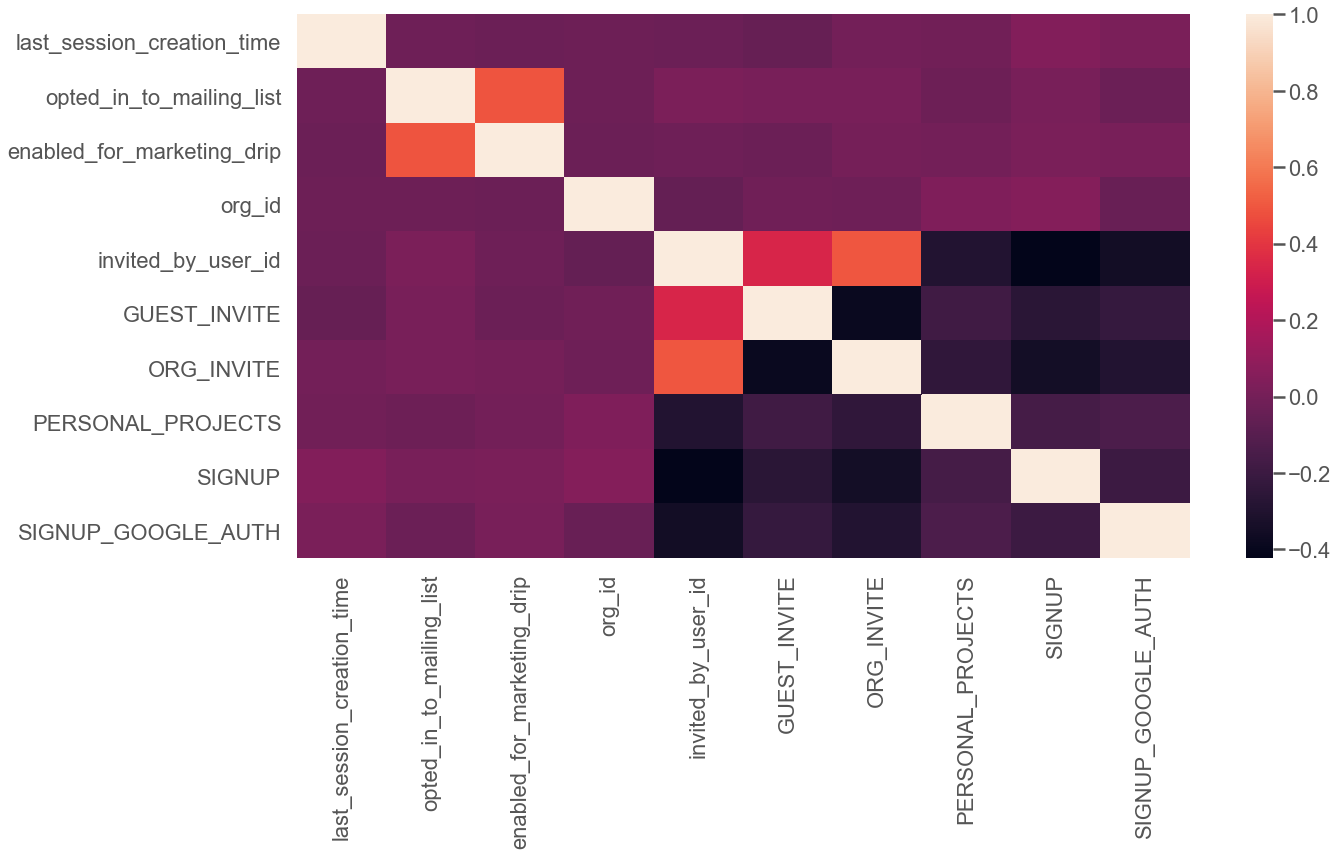

In [35]:
sns.heatmap(df_features.corr())

In [31]:
#convert columns to float64
for col in df_features.columns:
    df_features[col] = df_features[col].astype('float64')
df_features.head()
df_features.fillna(0,inplace=True)

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,FastICA

#scale data
scaler = StandardScaler()
features = scaler.fit_transform(df_features)

#fit PCA
pca = PCA()
components = pca.fit_transform(features)

ica=FastICA()
components=ica.fit_transform(features)

/Users/lilie/Applications/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [45]:
df_comp = pd.DataFrame(ica.components_,columns=df_features.columns,index=['IC-1','IC-2','IC-3','IC-4','IC-5','IC-6','IC-7','IC-8','IC-9','IC-10'])
#absolute values of correlation with principal components
best_features = np.absolute(df_comp[np.absolute(df_comp) > 0.1])
best_features.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
IC-1,NaN,NaN,NaN,NaN,NaN,2.250923e+13,2.550655e+13,1.627919e+13,2.113957e+13,1.882808e+13
IC-2,NaN,NaN,NaN,NaN,NaN,2.966588e+13,3.361618e+13,2.145504e+13,2.786074e+13,2.481434e+13
IC-3,NaN,NaN,NaN,NaN,NaN,2.196799e+13,2.489324e+13,1.588775e+13,2.063126e+13,1.837536e+13
IC-4,NaN,NaN,NaN,NaN,NaN,2.570076e+13,2.912307e+13,1.858738e+13,2.413690e+13,2.149767e+13
IC-5,NaN,NaN,NaN,NaN,NaN,2.587149e+13,2.931653e+13,1.871086e+13,2.429724e+13,2.164048e+13


In [43]:
df_comp = pd.DataFrame(pca.components_,columns=df_features.columns,index=['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9','PC-10'])
#absolute values of correlation with principal components
best_features_pca = np.absolute(df_comp[np.absolute(df_comp) > 0.1])
best_features_pca.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
PC-1,NaN,NaN,NaN,NaN,0.637653,0.232628,0.486575,0.233976,0.390324,0.296733
PC-2,NaN,0.695712,0.69891,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PC-3,0.116892,NaN,NaN,NaN,NaN,0.784060,0.590037,NaN,NaN,NaN
PC-4,NaN,NaN,NaN,0.261476,NaN,NaN,NaN,0.108246,0.648711,0.697782
PC-5,0.230407,NaN,NaN,0.219055,NaN,NaN,NaN,0.825688,0.296054,0.350811


In [44]:
best_features_pca.head(7).sum(axis=0).sort_values(ascending=False)

org_id                        1.792770
SIGNUP_GOOGLE_AUTH            1.705164
last_session_creation_time    1.700941
SIGNUP                        1.524752
PERSONAL_PROJECTS             1.438816
ORG_INVITE                    1.076612
GUEST_INVITE                  1.016688
enabled_for_marketing_drip    0.698910
opted_in_to_mailing_list      0.695712
invited_by_user_id            0.637653
dtype: float64

In [40]:
best_features.head(7).sum(axis=0).sort_values(ascending=False)

ORG_INVITE                    1.604081e+14
GUEST_INVITE                  1.415582e+14
SIGNUP                        1.329445e+14
SIGNUP_GOOGLE_AUTH            1.184079e+14
PERSONAL_PROJECTS             1.023781e+14
invited_by_user_id            0.000000e+00
org_id                        0.000000e+00
enabled_for_marketing_drip    0.000000e+00
opted_in_to_mailing_list      0.000000e+00
last_session_creation_time    0.000000e+00
dtype: float64